# Pràctica 3 - PLH

### Realitzada pels alumnes Lluc Furriols i Pau Prat Moreno

In [2]:
'''
import os 
f = open("/dev/null", "w")
os.dup2(f.fileno(), 2)
f.close()

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()
'''

'\nimport os \nf = open("/dev/null", "w")\nos.dup2(f.fileno(), 2)\nf.close()\n\nimport nltk\nimport ssl\n\ntry:\n    _create_unverified_https_context = ssl._create_unverified_context\nexcept AttributeError:\n    pass\nelse:\n    ssl._create_default_https_context = _create_unverified_https_context\n\nnltk.download()\n'

In [1]:
import nltk
nltk.download('punkt', quiet=True) # Tokenitzador
nltk.download('averaged_perceptron_tagger', quiet=True) # Etiquetador POS
nltk.download('maxent_ne_chunker', quiet=True) # Etiquetador Entitats Anomenades
nltk.download('words', quiet=True)

True

In [2]:
nltk.download('conll2002')
from nltk.corpus import conll2002

train_esp = conll2002.iob_sents('esp.train') # Train, 
val_esp = conll2002.iob_sents('esp.testa') # Val
test_esp = conll2002.iob_sents('esp.testb') # Test

train_ned = conll2002.iob_sents('ned.train') # Train
val_ned = conll2002.iob_sents('ned.testa') # Val
test_ned = conll2002.iob_sents('ned.testb') # Test

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


In [3]:
train_esp

[[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')], [('-', 'Fg', 'O')], ...]

In [4]:
def get_token_entity(sequence):
    """
    Retorna una llista de llistes on cada llista interna conté tuples del token i la seva entitat.
    """
    return [[(token, entity) for token, pos, entity in sentence] for sentence in sequence]

In [20]:
def extract_entities(tagged_words):
    entities = []
    current_entity = []
    current_type = None
    current_start_index = None  # Afegim una variable per guardar l'índex d'inici

    for index, (word, tag) in enumerate(tagged_words):
        if tag.startswith('B-'):  # Començament d'una nova entitat
            if current_entity:  # Si hi havia una entitat en construcció, l'afegim abans de començar la nova
                entities.append((current_start_index, index - 1, current_type))
            current_entity = [word]  # Comencem una nova entitat
            current_start_index = index  # Guardem l'índex d'inici de l'entitat actual
            current_type = tag[2:]  # Guardem el tipus d'entitat sense el prefix B-
        elif tag.startswith('I-') and current_type == tag[2:]:  # Continuació de la mateixa entitat
            current_entity.append(word)
        else:  # Si no és una continuació de la mateixa entitat o és 'O'
            if current_entity:  # Finalitzem l'entitat actual si n'hi ha una
                entities.append((current_start_index, index - 1, current_type))
                current_entity = []
                current_type = None
            if tag == 'O':
                continue
            else:  # Codificació IO o canvi d'entitat amb I-
                current_entity = [word]
                current_start_index = index
                current_type = tag[2:]  # Possible en cas de codificació IO

    # Assegurar-se d'afegir l'última entitat si la llista no acaba en 'O'
    if current_entity:
        entities.append((current_start_index, index, current_type))

    return entities

# Exemple d'ús:
tagged_words = [('Madrid', 'B-LOC'), ('es', 'O'), ('muy', 'O'), ('bonito', 'O'),
                ('Juan', 'B-PER'), ('Carlos', 'I-PER'), ('Rivera', 'I-PER'), ('vive', 'O'),
                ('en', 'O'), ('Barcelona', 'B-LOC')]

entities = extract_entities(tagged_words)
print(entities)


[(0, 0, 'LOC'), (4, 6, 'PER'), (9, 9, 'LOC')]


In [14]:
import string

class FeatureGetter:
    """
    Aquesta classe s'utilitza per obtenir diferents característiques d'un token de text.
    """
    def __init__(self):
        pass

    def has_capitalization(self, token):
        """
        Comprova si el token conté alguna lletra majúscula.
        """
        return any(char.isupper() for char in token)

    def has_digit(self, token):
        """
        Comprova si el token conté algun dígit.
        """
        return any(char.isdigit() for char in token)

    def has_punctuation(self, token):
        """
        Comprova si el token conté algun signe de puntuació.
        """
        return any(char in string.punctuation for char in token)

    def get_prefix(self, token, n=3):
        """
        Obté el prefix del token amb una longitud de n caràcters.
        """
        return token[:n] if len(token) > n else token

    def get_suffix(self, token, n=3):
        """
        Obté el sufix del token amb una longitud de n caràcters.
        """
        return token[-n:] if len(token) > n else token

    def all_caps(self, token):
        """
        Comprova si totes les lletres del token són majúscules.
        """
        return token.isupper()

    def is_capitalized(self, token):
        """
        Comprova si la primera lletra del token és majúscula.
        """
        return token[0].isupper()

    def get_features(self, token, add_prefix_suffix=True):
        """
        Obté un diccionari amb les característiques del token.
        """
        features = {
            'bias': 1.0,
            'has_capitalization': self.has_capitalization(token),
            'has_digit': self.has_digit(token),
            'has_punctuation': self.has_punctuation(token),
            'all_caps': self.all_caps(token),
            'is_capitalized': self.is_capitalized(token),
        }

        if add_prefix_suffix:
            features['prefix'] = self.get_prefix(token)
            features['suffix'] = self.get_suffix(token)

        return features

# Exemple d'ús:
feature_getter = FeatureGetter()
token_features = feature_getter.get_features('Barcelona')
print(token_features)

{'bias': 1.0, 'has_capitalization': True, 'has_digit': False, 'has_punctuation': False, 'all_caps': False, 'is_capitalized': True, 'prefix': 'Bar', 'suffix': 'ona'}


[('Melbourne', 'B-LOC'), ('(', 'O'), ('Australia', 'B-LOC'), (')', 'O'), (',', 'O'), ('25', 'O'), ('may', 'O'), ('(', 'O'), ('EFE', 'B-ORG'), (')', 'O'), ('.', 'O')]
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']
['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']


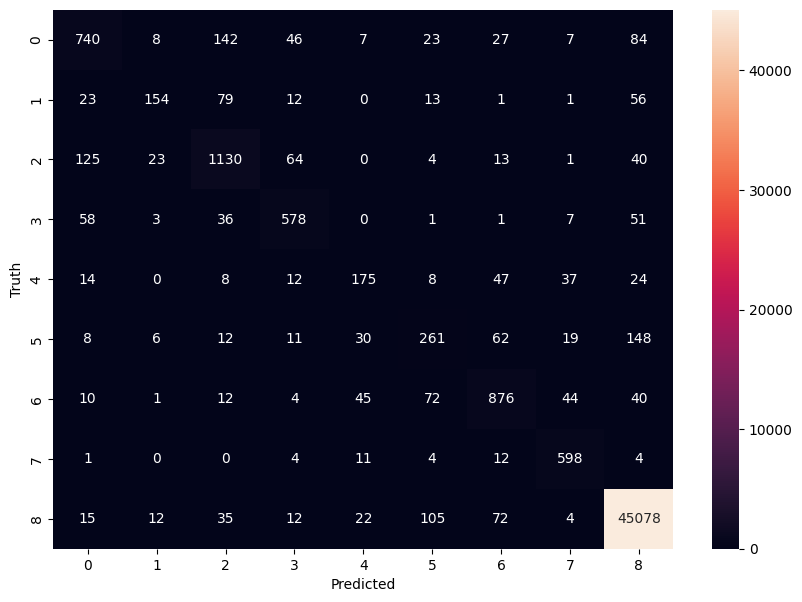

              precision    recall  f1-score   support

       B-LOC       0.74      0.68      0.71      1084
      B-MISC       0.74      0.45      0.56       339
       B-ORG       0.78      0.81      0.79      1400
       B-PER       0.78      0.79      0.78       735
       I-LOC       0.60      0.54      0.57       325
      I-MISC       0.53      0.47      0.50       557
       I-ORG       0.79      0.79      0.79      1104
       I-PER       0.83      0.94      0.88       634
           O       0.99      0.99      0.99     45355

    accuracy                           0.96     51533
   macro avg       0.75      0.72      0.73     51533
weighted avg       0.96      0.96      0.96     51533



0.9622960045019696

In [7]:
'''from nltk.tag import CRFTagger
import pycrfsuite

ct = CRFTagger(feature_func=None)
#train and test sets without the postag
train_esp_bio = get_token_entity(train_esp)
test_esp_bio = get_token_entity(test_esp)
print(train_esp_bio[0])

#y_test is the true labels
y_test = [[iob for word, iob in sent] for sent in test_esp_bio]
print(y_test[0])

#train the model
ct.train(train_esp_bio, 'model.crf.tagger')

#predict the labels
y_pred = ct.tag_sents([[word for word, iob in sent] for sent in test_esp_bio])
y_pred = [[iob for word, iob in sent] for sent in y_pred]
print(y_pred[0])


#show the confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Flatten y_test and y_pred
y_test_flat = [iob for sent in y_test for iob in sent]
y_pred_flat = [iob for sent in y_pred for iob in sent]

# Generate confusion matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)

# Visualize confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#show the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_flat, y_pred_flat))
ct.accuracy(test_esp_bio)'''